In [602]:
import pandas as pd
import mysql.connector
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt


In [603]:
# connection to MYSQL DB
def get_dataframe_from_database(query):
    config = {
        'user': 'root',
        'host': '127.0.0.1',
        'password': 'Aloha@20',
        'port': 3306,
        'database': 'uber_analytics',
    }

    connection= mysql.connector.connect(**config)
    cursor= connection.cursor()
    cursor.execute(query)

    rows= cursor.fetchall()
    df = pd.DataFrame(rows,columns=cursor.column_names)
    
    cursor.close()
    connection.close()
    return df




In [604]:
query = """SELECT client_uuid, COUNT(job_uuid) as num_trips
FROM tbl_trip_data
GROUP BY client_uuid;"""
df = get_dataframe_from_database(query)

In [605]:
df.head()

,client_uuid,num_trips
0,4579,4
1,4758,1
2,4886,1
3,2930,6
4,349,1


In [606]:
average_trips_per_rider = df['num_trips'].mean()
print(f"Average Trips per Rider: {average_trips_per_rider:.2f}")


Average Trips per Rider: 1.68


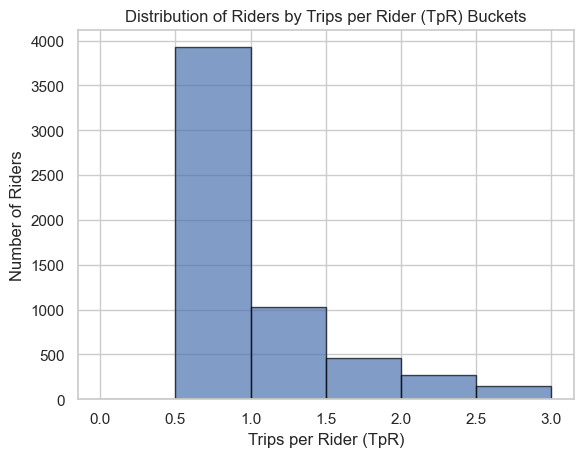

In [607]:
# Calculate TpR for each rider
df['tpr'] = df['num_trips'] / average_trips_per_rider

# Define the TpR buckets
buckets = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# Plot the histogram
plt.hist(df['tpr'], bins=buckets, edgecolor='black', alpha=0.7)
plt.xlabel('Trips per Rider (TpR)')
plt.ylabel('Number of Riders')
plt.title('Distribution of Riders by Trips per Rider (TpR) Buckets')
plt.xticks(buckets)
plt.show()


In [608]:
query = """SELECT client_uuid, COUNT(job_uuid) as num_trips
FROM tbl_trip_data
WHERE is_subs_trip = 'TRUE'
GROUP BY client_uuid;"""
df = get_dataframe_from_database(query)

In [609]:
average_trips_per_rider = df['num_trips'].mean()
print(f"Average Trips per Rider: {average_trips_per_rider:.2f}")

Average Trips per Rider: 1.99


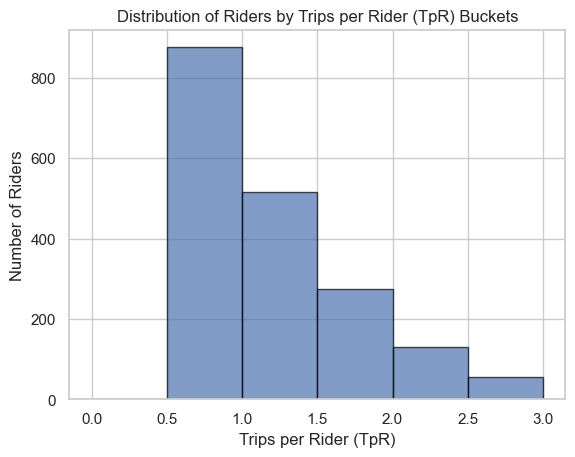

In [610]:


# Calculate TpR for each rider
df['tpr'] = df['num_trips'] / average_trips_per_rider

# Define the TpR buckets
buckets = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# Plot the histogram
plt.hist(df['tpr'], bins=buckets, edgecolor='black', alpha=0.7)
plt.xlabel('Trips per Rider (TpR)')
plt.ylabel('Number of Riders')
plt.title('Distribution of Riders by Trips per Rider (TpR) Buckets')
plt.xticks(buckets)
plt.show()

In [611]:
query = """SELECT
COUNT(CASE WHEN status = 'completed' THEN 1 END) / COUNT(*) AS fulfillment_rate,
COUNT(CASE WHEN status = 'rider_canceled' THEN 1 END) / COUNT(*) AS rider_cancellation_rate,
COUNT(CASE WHEN status = 'driver_canceled' THEN 1 END) / COUNT(*) AS driver_cancellation_rate
FROM uber_analytics.tbl_trip_data;"""
df = get_dataframe_from_database(query)
df.head()

,fulfillment_rate,rider_cancellation_rate,driver_cancellation_rate
0,0.6584,0.2696,0.0664


In [612]:
df['fulfillment_rate'] *= 100
df['rider_cancellation_rate'] *= 100
df['driver_cancellation_rate'] *= 100

fulfillment_rate = df['fulfillment_rate'][0]
rider_cancellation_rate = df['rider_cancellation_rate'][0]
driver_cancellation_rate = df['driver_cancellation_rate'][0]

print(f'Fulfillment Rate is {fulfillment_rate:.2f}%')
print(f'Rider Cancellation Rate is {rider_cancellation_rate:.2f}%')
print(f'Driver Cancellation Rate is {driver_cancellation_rate:.2f}%')

Fulfillment Rate is 65.84%
Rider Cancellation Rate is 26.96%
Driver Cancellation Rate is 6.64%


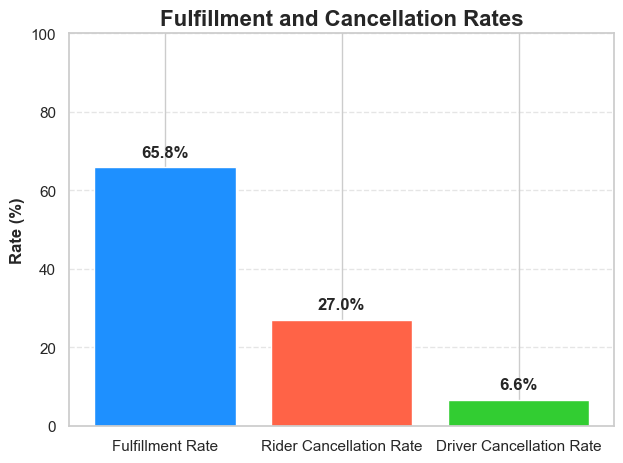

In [613]:
rates = ['Fulfillment Rate', 'Rider Cancellation Rate', 'Driver Cancellation Rate']
values = [fulfillment_rate, rider_cancellation_rate, driver_cancellation_rate]


colors = ['dodgerblue', 'tomato', 'limegreen']
plt.bar(rates, values, color=colors)

# Adding data labels on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Rate (%)', fontsize=12, fontweight='bold')
plt.title('Fulfillment and Cancellation Rates', fontsize=16, fontweight='bold')
plt.ylim(0, 100)

# Adding a subtle grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding some padding to the layout
plt.tight_layout()

plt.show()

In [614]:
query = """SELECT HOUR(begintrip_date_time) AS hour_of_day, DAYOFWEEK(begintrip_date_time) AS day_of_week,
       COUNT(CASE WHEN status = 'completed' THEN 1 END) / COUNT(*) AS fulfillment_rate
FROM uber_analytics.tbl_trip_data
WHERE begintrip_date_time IS NOT NULL
GROUP BY hour_of_day, day_of_week;"""
df = get_dataframe_from_database(query)
df.head()

,hour_of_day,day_of_week,fulfillment_rate
0,17,1,0.9835
1,7,3,0.9959
2,8,1,0.9776
3,7,5,0.9953
4,8,4,0.9964


In [615]:
# mapping the days of the week

day_mapping = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday',
     }

df['fulfillment_rate'] *= 100
df['day_of_week']= df['day_of_week'].map(day_mapping)
df.head()

,hour_of_day,day_of_week,fulfillment_rate
0,17,Sunday,98.3500
1,7,Tuesday,99.5900
2,8,Sunday,97.7600
3,7,Thursday,99.5300
4,8,Wednesday,99.6400


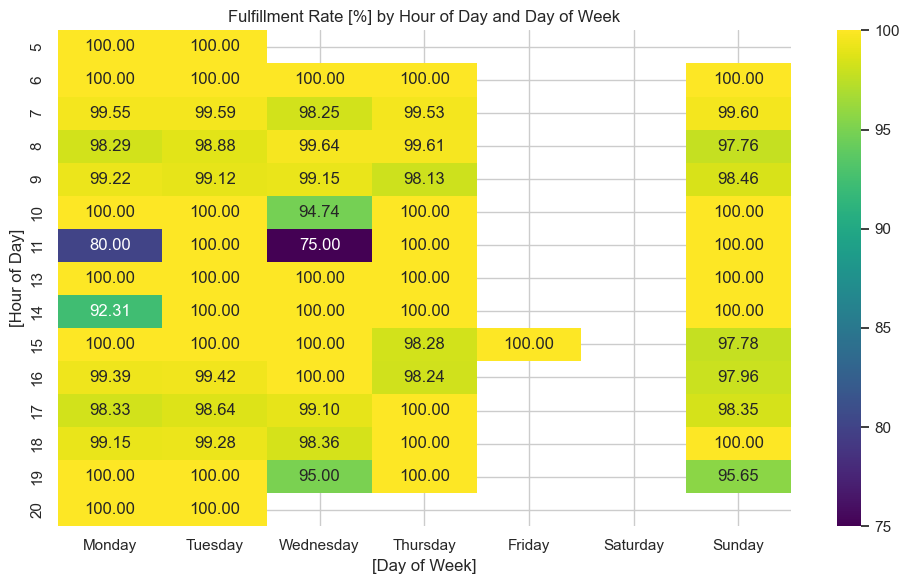

In [616]:

# Plotting

df['fulfillment_rate'] = df['fulfillment_rate'].astype(float)
df = df.sort_values(by=['day_of_week', 'hour_of_day'])

heatmap_data = df.pivot_table(index='hour_of_day', columns='day_of_week', values='fulfillment_rate', aggfunc='mean')

days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(sorted(df['hour_of_day'].unique()), columns=days_of_week_order)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.2f', cbar=True)
plt.title('Fulfillment Rate [%] by Hour of Day and Day of Week')
plt.xlabel('[Day of Week]')
plt.ylabel('[Hour of Day]')

plt.tight_layout()
plt.show()

In [617]:
query = """SELECT request_type, TIMESTAMPDIFF(MINUTE, request_date_time, begintrip_date_time) AS trip_duration_minutes, COUNT(*) AS num_trips
FROM uber_analytics.tbl_trip_data
WHERE request_type IN ('MICROSCHEDULING','PRESCHEDULING')
GROUP BY trip_duration_minutes,request_type;"""
df = get_dataframe_from_database(query)
df.head()

,request_type,trip_duration_minutes,num_trips
0,MICROSCHEDULING,31.0,38
1,PRESCHEDULING,NaN,2608
2,MICROSCHEDULING,20.0,67
3,MICROSCHEDULING,22.0,53
4,PRESCHEDULING,10.0,62


In [618]:
df.isna().sum() # these were the trips that never began , hence the difference of values are 'null'

request_type             0
trip_duration_minutes    2
num_trips                0
dtype: int64

In [619]:
df= df.dropna() # dropping NaN values
df.isna().sum()


request_type             0
trip_duration_minutes    0
num_trips                0
dtype: int64

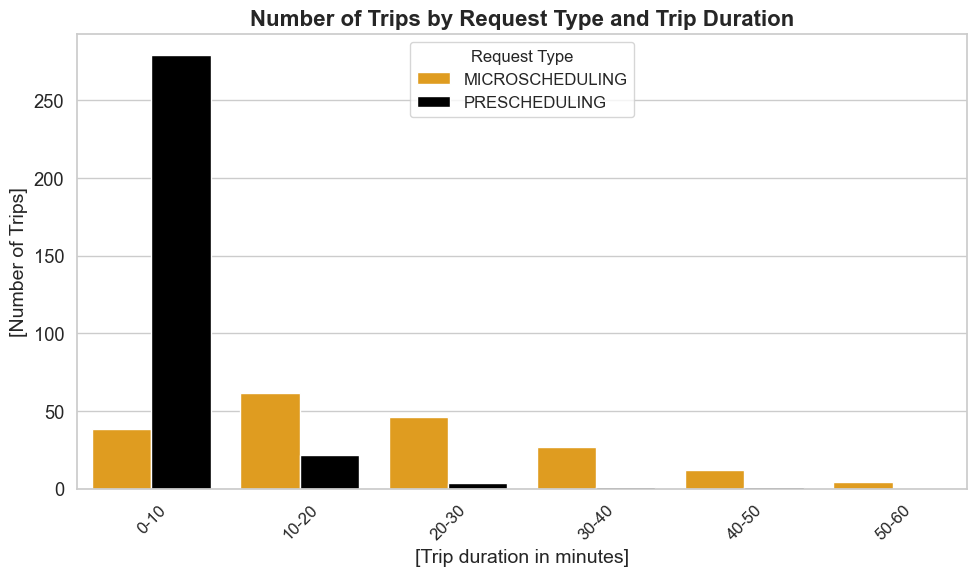

In [620]:
# Set a modern style using Seaborn
sns.set_theme(style="whitegrid", font_scale=1.2)

# allocating bins
bins = pd.cut(df['trip_duration_minutes'], bins=[0, 10, 20, 30, 40, 50,60])

# Create a clustered bar plot using Seaborn
plt.figure(figsize=(10, 6))
color_palette = {'PRESCHEDULING': 'black', 'MICROSCHEDULING': 'orange'}
sns.barplot(data=df, x=bins, y='num_trips', hue='request_type', errorbar=None, palette=color_palette)
plt.title('Number of Trips by Request Type and Trip Duration', fontweight='bold', fontsize=16)
plt.xlabel('[Trip duration in minutes]', fontsize=14)
plt.ylabel('[Number of Trips]', fontsize=14)

# Set custom x-axis labels
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60']
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, fontsize=12)

# Customize the legend and labels
plt.legend(title='Request Type', fontsize=12, title_fontsize=12)
plt.tight_layout()

# Display the visual
plt.show()

In [621]:
query ="""SELECT
    HOUR(begintrip_date_time) AS hour_of_day,
    DAYOFWEEK(begintrip_date_time) AS day_of_week,
    COUNT(*) AS num_trips_hour_day
FROM uber_analytics.tbl_trip_data
WHERE begintrip_date_time IS NOT NULL  -- since NULL values denote that the trip had never begun.
GROUP BY hour_of_day, day_of_week;"""
df = get_dataframe_from_database(query)
df.head()


,hour_of_day,day_of_week,num_trips_hour_day
0,17,1,242
1,7,3,241
2,8,1,312
3,7,5,215
4,8,4,277


In [622]:

# mapping the days of the week
day_mapping = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday',
     }

df['day_of_week']= df['day_of_week'].map(day_mapping)
df.head()

,hour_of_day,day_of_week,num_trips_hour_day
0,17,Sunday,242
1,7,Tuesday,241
2,8,Sunday,312
3,7,Thursday,215
4,8,Wednesday,277


In [623]:
# Sorting columns
df = df.sort_values(by=['day_of_week', 'hour_of_day'])
# Pivot the data
heatmap_data = df.pivot_table(
    index='hour_of_day', columns='day_of_week', values='num_trips_hour_day', aggfunc='sum'
)

days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(sorted(df['hour_of_day'].unique()), columns=days_of_week_order)

# Create the Plotly heatmap trace
heatmap_trace = go.Heatmap(
    z=heatmap_data.values,
    x=days_of_week_order,
    y=sorted(df['hour_of_day'].unique()),
    colorscale='Viridis',
    colorbar=dict(title='Number of Trips')
)

# Set layout
layout = go.Layout(
    title='Number of Trips by Hour of Day and Day of Week',
    xaxis=dict(title='Day of Week', automargin=True),
    yaxis=dict(title='Hour of Day', automargin=True),
    width=900,  # Set the width to your desired value
)

# Create the figure and add the trace
fig = go.Figure(data=[heatmap_trace], layout=layout)

# Show the plot
fig.show()

In [624]:
query ="""SELECT
    payment_method,
    COUNT(*) AS num_trips_payment_method
FROM uber_analytics.tbl_trip_data
GROUP BY payment_method;"""
df = get_dataframe_from_database(query)
df.head()


,payment_method,num_trips_payment_method
0,cash,7751
1,Visa,655
2,MasterCard,1020
3,stored_value,268
4,derivative,303


In [625]:
# Plotting
fig = px.bar(df, x='payment_method', y='num_trips_payment_method', text='num_trips_payment_method', 
             title='Number of Trips by Payment Method', labels={'num_trips_payment_method': 'Num Trips'},
             color_discrete_sequence=px.colors.qualitative.Dark2)

# Customize the layout
fig.update_layout(
    xaxis_title='Payment Method',
    yaxis_title='Number of Trips',
    title_x=0.5,
    xaxis=dict(type='category'),
    showlegend=False
)

# Display the plot
fig.show()








In [626]:
query ="""
SELECT
    vehicle_capacity,
    ROUND(AVG(usage_count / vehicle_capacity), 2) AS avg_utilization
FROM (
    SELECT
        vi.vehicle_capacity,
        COUNT(vi.vehicle_capacity) AS usage_count
    FROM uber_analytics.tbl_vehicle_info vi
    INNER JOIN uber_analytics.tbl_trip_data td ON td.vehicle_uuid = vi.vehicle_uuid
    WHERE td.status = 'completed'
    GROUP BY vi.vehicle_capacity
) AS subquery
GROUP BY vehicle_capacity;

"""
df = get_dataframe_from_database(query)
df.head()


,vehicle_capacity,avg_utilization
0,15,6506.60
1,14,2764.50
2,13,62.00
3,23,18.78
4,11,198.18


In [627]:
df['avg_utilization'] = pd.to_numeric(df['avg_utilization'], errors='coerce').round(2) 
df.isna().sum() # looking for Nan/None values

vehicle_capacity    0
avg_utilization     0
dtype: int64

In [628]:
df= df.dropna() # Dropping Nan Values as all columns for that particular row have no entries.
df.isna().sum()

vehicle_capacity    0
avg_utilization     0
dtype: int64

In [629]:
df = df.sort_values(by=['vehicle_capacity'])
fig = px.bar(df, x='vehicle_capacity', y='avg_utilization', 
             title='Average Utilization by Vehicle Capacity',
             labels={'vehicle_capacity': 'Vehicle Capacity', 'avg_utilization': 'Average Utilization'},
             template='plotly_dark',  # Use the dark theme
             text='avg_utilization',  # Display text on hover
             hover_data={'avg_utilization': ':.2f'})  # Format hover text to 2 decimal places

# Adjust axis properties
fig.update_layout(
    xaxis={'tickvals': df['vehicle_capacity'],'title_standoff': 10},
    yaxis={'title_standoff': 10}
)
fig.show()

In [630]:
query ="""
SELECT client_uuid,SUM(pickup_walking_distance) AS total_walking_distance,
       (SUM(pickup_walking_distance)/COUNT(*) )AS avg_walking_distance,
       COUNT(*) AS num_trips
	
FROM uber_analytics.tbl_trip_data
GROUP BY client_uuid
ORDER BY total_walking_distance ;
"""
df = get_dataframe_from_database(query)
df.head(10)


,client_uuid,total_walking_distance,avg_walking_distance,num_trips
0,4822,None,None,1
1,3775,None,None,1
2,3587,None,None,1
3,328,None,None,1
4,2757,None,None,1
5,1535,None,None,1
6,835,None,None,1
7,1105,None,None,1
8,3395,None,None,1
9,5267,None,None,1


In [631]:
df = df.dropna() # dropping NULL values since it denotes that the trips never began.
df.isna().sum()
df.tail()

,client_uuid,total_walking_distance,avg_walking_distance,num_trips
5949,2414,17944.55700,17944.557000000,1
5950,5890,19509.92000,19509.920000000,1
5951,662,32594.03100,32594.031000000,1
5952,5909,36725.56200,36725.562000000,1
5953,4209,62639.20734,15659.801835000,4


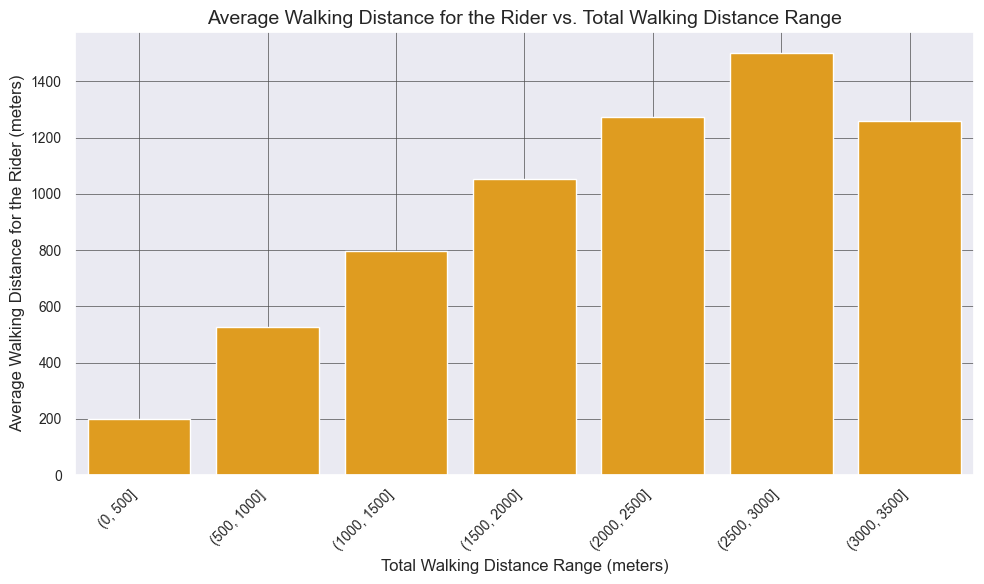

In [632]:
# assigning bucket range and step
buckets = np.arange(0, 4000, 500)

# Assign each row to a bucket
df['bucket'] = pd.cut(df['total_walking_distance'], bins=buckets)

# Group by bucket and calculate the average walking distance for each bucket
bucket_avg = df.groupby('bucket')['avg_walking_distance'].mean()

# Set the theme
sns.set_theme(color_codes=True, font="sans-serif", style="darkgrid", palette="coolwarm")

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=bucket_avg.index.astype(str), y=bucket_avg.values,color='orange')
plt.xlabel('Total Walking Distance Range (meters)', fontsize=12)
plt.ylabel('Average Walking Distance for the Rider (meters)', fontsize=12)
plt.title('Average Walking Distance for the Rider vs. Total Walking Distance Range', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Customize the grid color for a more seamless dark theme
ax.grid(color='0.3', linestyle='-', linewidth=0.5)

# Show the plot
plt.show()

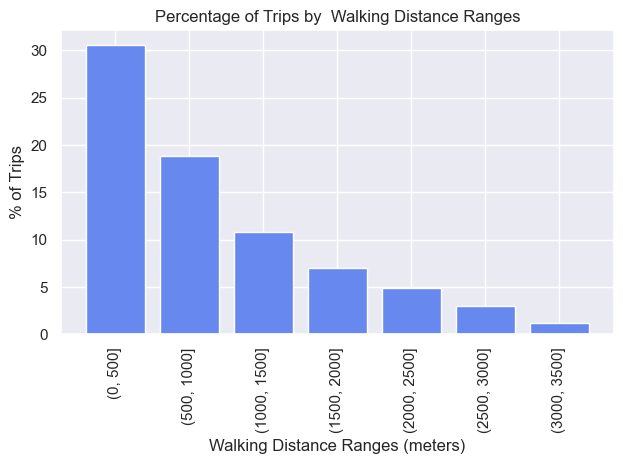

In [633]:
# calculating total trips
total_trips = df['num_trips'].sum()

# Group by bucket and calculate the percentage of trips for each bucket
bucket_percentage = df.groupby('bucket')['num_trips'].sum() / total_trips * 100


# Plotting
sns.set_theme(color_codes=True, font="sans-serif", style="darkgrid", palette="coolwarm")
plt.bar(bucket_percentage.index.astype(str), bucket_percentage.values)
plt.xlabel('Walking Distance Ranges (meters)')
plt.ylabel('% of Trips')
plt.title('Percentage of Trips by  Walking Distance Ranges')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [634]:
query ="""
SELECT trip_distance_miles, 
       TIMESTAMPDIFF(MINUTE, begintrip_date_time, dropoff_date_time) AS trip_duration_minutes
FROM `uber_analytics`.`tbl_trip_data`
WHERE status = 'completed';
"""
df = get_dataframe_from_database(query)
df.head(10)


,trip_distance_miles,trip_duration_minutes
0,17.306313,48
1,17.107595,26
2,7.345371,30
3,9.439092,25
4,13.867314,56
5,24.376280,35
6,19.851208,85
7,12.327791,56
8,24.107786,53
9,35.206787,83


<Figure size 1200x600 with 0 Axes>

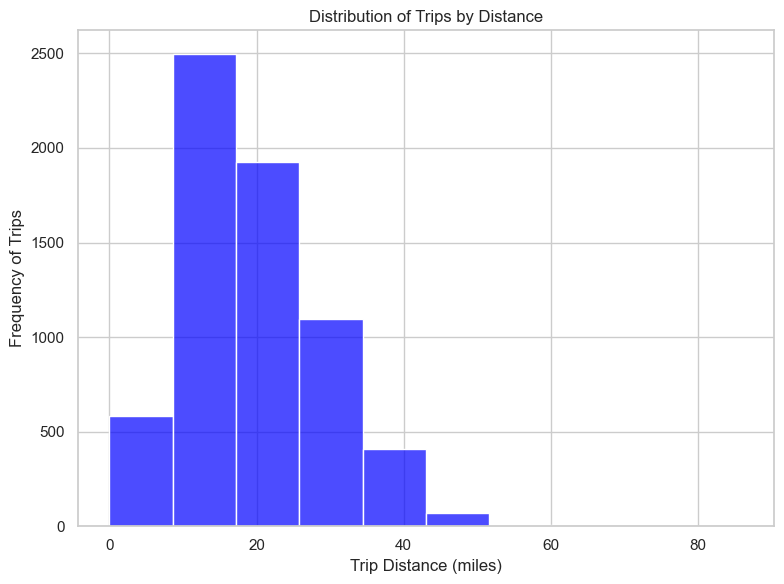

In [638]:
plt.figure(figsize=(12, 6))

# Set Seaborn style
sns.set(style="whitegrid")

# Create a single plot for the distribution of trips by distance
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='trip_distance_miles', bins=10, color='blue', alpha=0.7)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency of Trips')
plt.title('Distribution of Trips by Distance')
plt.tight_layout()

plt.show()


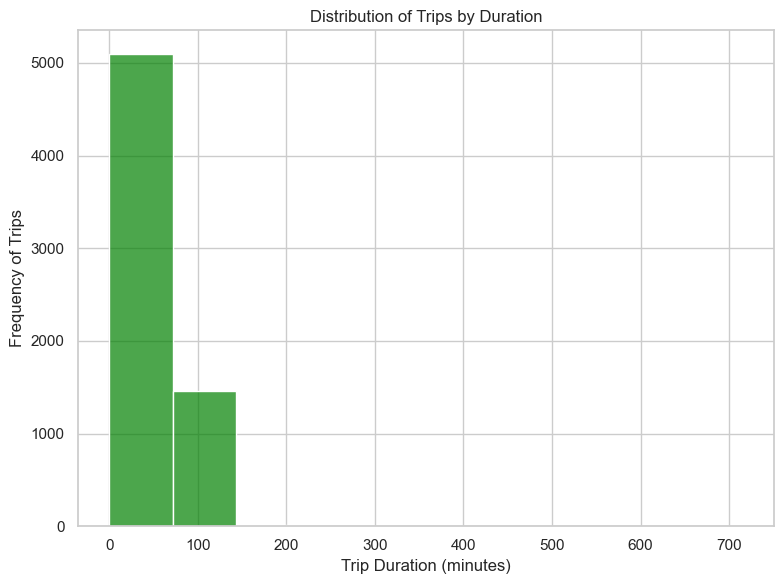

In [636]:
# Plot 1=2: Distribution of trips by duration

# Set Seaborn style
sns.set(style="whitegrid")

# Create a single plot for the distribution of trips by duration
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='trip_duration_minutes', bins=10, color='green', alpha=0.7)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency of Trips')
plt.title('Distribution of Trips by Duration')
plt.tight_layout()

plt.show()